# **Bone Fracture Detection**
This notebook demonstrates binary classification using a custom CNN model.

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import ImageFile
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### **1. Data Preparation**

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
dataset_path = os.getcwd()
train_dir = os.path.join(dataset_path, r"C:\Users\aer\.cache\kagglehub\datasets\osamajalilhassan\bone-fracture-dataset\versions\1\BoneFractureDataset\training")
test_dir = os.path.join(dataset_path, r"C:\Users\aer\.cache\kagglehub\datasets\osamajalilhassan\bone-fracture-dataset\versions\1\BoneFractureDataset\testing")

# Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

training_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode="binary",
    shuffle=False
)

filenames = np.array(training_gen.filenames)
labels = np.array(training_gen.classes).astype(str) 

Found 8863 images belonging to 2 classes.


In [7]:
import os

# Check if the train directory exists
print(os.path.exists(train_dir))  # Should print True if the path exists

# If the path doesn't exist, print the full path to help locate the issue
print(train_dir)


True
C:\Users\aer\.cache\kagglehub\datasets\osamajalilhassan\bone-fracture-dataset\versions\1\BoneFractureDataset\training


### **1.1 Visualize Class Distribution**

Found 8863 images belonging to 2 classes.


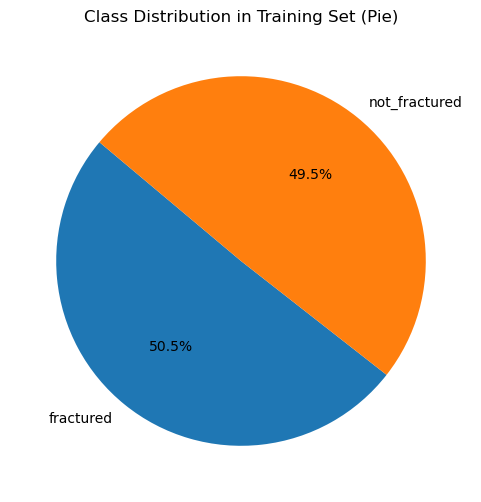

In [8]:
def plot_class_distribution(generator):
    class_counts = generator.classes
    unique, counts = np.unique(class_counts, return_counts=True)
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=generator.class_indices.keys(), autopct='%1.1f%%', startangle=140)
    plt.title("Class Distribution in Training Set (Pie)")
    plt.show()

temp_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode="binary",
    shuffle=False
)
plot_class_distribution(temp_gen)

### **1.2 Visualize Augmented Images**

Found 8863 images belonging to 2 classes.


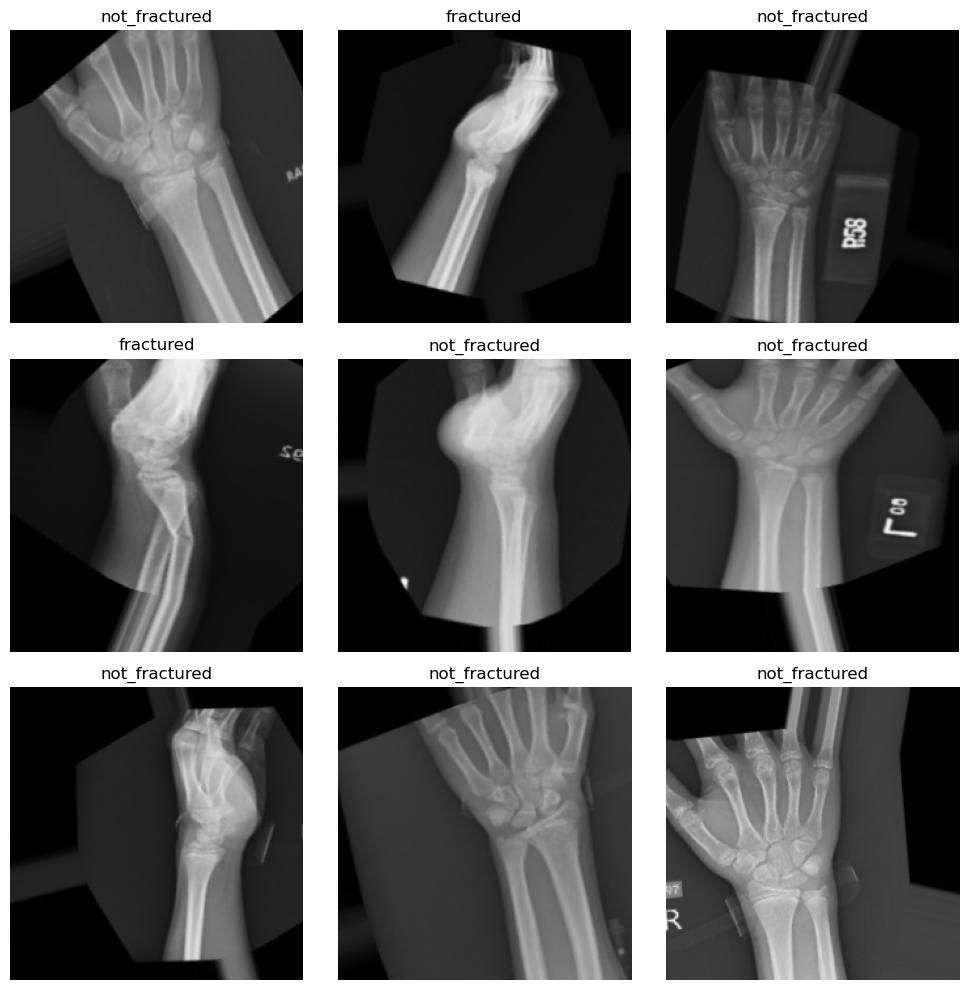

In [9]:
def plot_augmented_images(generator, num_images=9):
    images, labels = next(generator)
    class_labels = list(generator.class_indices.keys()) 
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_text = class_labels[int(labels[i])] 
        plt.title(f"{label_text}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

augmented_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary"
)
plot_augmented_images(augmented_gen)

### **2. Model Definition**

In [10]:
model = models.Sequential([
    
    layers.InputLayer(input_shape=(224, 224, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall(name='recall')])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                     

### **3. 5-Fold Cross-Validation**

In [ ]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold_no = 1

fold_accuracies, fold_recalls, fold_precisions, fold_f1_scores = [], [], [], []

for train_index, val_index in kf.split(filenames):
    print(f"\n--- Starting Fold {fold_no} ---")
    
    # Split filenames and labels
    train_filenames = filenames[train_index]
    train_labels = labels[train_index]
    val_filenames = filenames[val_index]
    val_labels = labels[val_index]
    
    # Create DataFrames for train and validation
    train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_filenames, 'class': val_labels})
    
    # Data Generators
    train_gen = datagen.flow_from_dataframe(
        train_df,
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=8,
        class_mode='binary',
        shuffle=True
    )
    val_gen = datagen.flow_from_dataframe(
        val_df,
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=8,
        class_mode='binary',
        shuffle=False
    )
    
    # Train the model
    callbacks = [
    ModelCheckpoint(f"model_fold_{fold_no}.h5", save_best_only=False, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=3)
    ]

    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=callbacks
    )
    
    # Evaluate model
    val_preds = (model.predict(val_gen) > 0.5).astype(int).flatten()
    val_true = val_gen.classes
    
    acc = accuracy_score(val_true, val_preds)
    recall = recall_score(val_true, val_preds)
    precision = precision_score(val_true, val_preds)
    f1 = f1_score(val_true, val_preds)
    
    fold_accuracies.append(acc)
    fold_recalls.append(recall)
    fold_precisions.append(precision)
    fold_f1_scores.append(f1)
    
    print(f"\nFold {fold_no} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    fold_no += 1


--- Starting Fold 1 ---
Found 4431 validated image filenames belonging to 2 classes.
Found 4432 validated image filenames belonging to 2 classes.
Epoch 1/20


554/554 [==============================] - 204s 365ms/step - loss: 0.7099 - accuracy: 0.5412 - recall: 0.5695 - val_loss: 0.7130 - val_accuracy: 0.5074 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
554/554 [==============================] - 198s 358ms/step - loss: 0.6724 - accuracy: 0.5796 - recall: 0.6082 - val_loss: 0.8931 - val_accuracy: 0.5142 - val_recall: 0.9918 - lr: 0.0010
Epoch 3/20
554/554 [==============================] - 222s 401ms/step - loss: 0.6476 - accuracy: 0.6044 - recall: 0.6764 - val_loss: 0.6402 - val_accuracy: 0.6031 - val_recall: 0.5126 - lr: 0.0010
Epoch 4/20
554/554 [==============================] - 216s 389ms/step - loss: 0.6255 - accuracy: 0.6387 - recall: 0.6873 - val_loss: 1.0133 - val_accuracy: 0.5201 - val_recall: 0.0481 - lr: 0.0010
Epoch 5/20
554/554 [==============================] - 200s 

### **4. Test Evaluation**

In [7]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Test Generator    
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode="binary",
    shuffle=False
)


# Plot ROC Curve and Calculate AUC
def plot_roc_auc(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc


Found 1931 images belonging to 2 classes.


Test Accuracy: 0.9917
Test Precision: 0.9946
Test Recall: 0.9882
Test F1-Score: 0.9914
Confusion Matrix on Test Data:


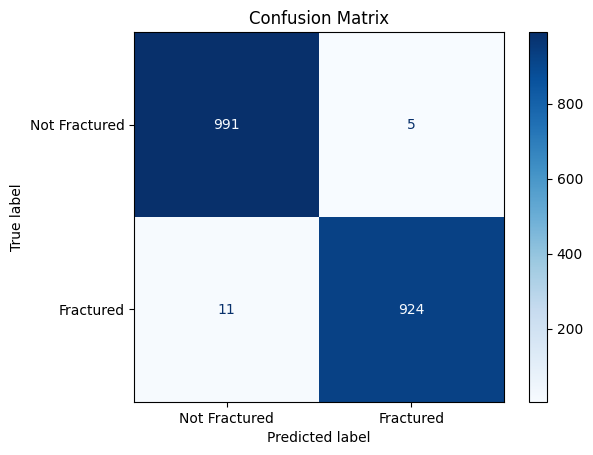

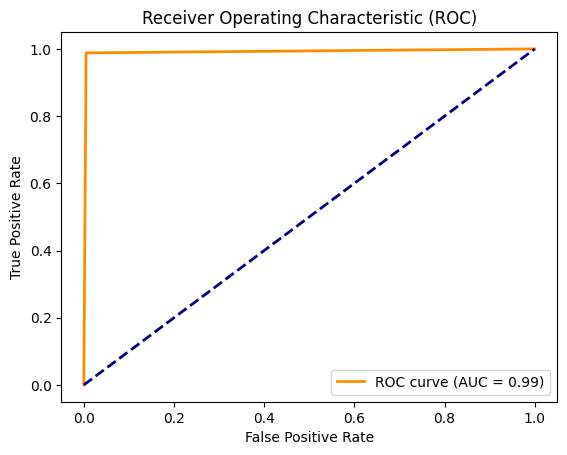

AUC: 0.99


In [11]:
# Evaluate on Test Data
test_preds = (model.predict(test_generator) > 0.5).astype(int).flatten()
test_true = test_generator.classes

# Compute Test Metrics
test_accuracy = accuracy_score(test_true, test_preds)
test_recall = recall_score(test_true, test_preds)
test_precision = precision_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds)

# Print Metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Plot Confusion Matrix
print("Confusion Matrix on Test Data:")
plot_confusion_matrix(test_true, test_preds, labels=["Not Fractured", "Fractured"])

auc_value = plot_roc_auc(test_true, test_preds)
print(f"AUC: {auc_value:.2f}")